<a href="https://colab.research.google.com/github/HMendesDev/Data-Science/blob/main/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro, spearmanr, pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import math

# Carregando e Conhecendo os dados

In [2]:
arq = "/content/drive/MyDrive/Data Science/Regressão/house_price_regression_dataset.csv"

In [3]:
df = pd.read_csv(arq, sep=",") # Carregando os dados

In [4]:
df.head() # 5 primeiras linhas

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,2.623829e+05
1,4272,3,3,2016,4.753014,1,6,9.852609e+05
2,3592,1,2,2016,3.634823,0,9,7.779774e+05
3,966,1,2,1977,2.730667,1,8,2.296989e+05
4,4926,2,1,1993,4.699073,0,8,1.041741e+06


In [5]:
df.tail() # 5 últimas linhas

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
995,3261,4,1,1978,2.165110,2,10,701493.997069
996,3179,1,2,1999,2.977123,1,10,683723.160704
997,2606,4,2,1962,4.055067,0,2,572024.023634
998,4723,5,2,1950,1.930921,0,7,964865.298639
999,3268,4,2,1983,3.108790,2,2,742599.253332


In [6]:
df.columns # Colunas de nosso dataset

Index(['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Year_Built',
       'Lot_Size', 'Garage_Size', 'Neighborhood_Quality', 'House_Price'],
      dtype='object')

# Limpeza e Transformação

In [7]:
df[df.duplicated()] # Verificando registros duplicados

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price


In [8]:
df.isnull().sum().sum() # Verificando registros nulos

np.int64(0)

In [9]:
df.shape[0] * df.shape[1] # Quantidade de registros em nosso dataset

8000

Nosso dataset não tem linhas duplicadas e nem registros nulos, porém vamos explorar posteriormente se encontramos registros sujos ou seja aqueles que não apresentam uma informação válida do dado em si e temos no total 8000 mil registros

In [10]:
df.info() # Verificando informações do dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Square_Footage        1000 non-null   int64  
 1   Num_Bedrooms          1000 non-null   int64  
 2   Num_Bathrooms         1000 non-null   int64  
 3   Year_Built            1000 non-null   int64  
 4   Lot_Size              1000 non-null   float64
 5   Garage_Size           1000 non-null   int64  
 6   Neighborhood_Quality  1000 non-null   int64  
 7   House_Price           1000 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 62.6 KB


Nosso dataset consiste em 8 variáveis, 1 delas sendo a variável target (House_price) e 7 delas que são características que podem influenciar na nossa variável target, vamos conhecer:

Square_Footage: Tamanho da casa em metros quadrados

Num_Bedrooms: O número de quartos na casa

Num_Bathrooms: O número de banheiros na casa

Year_Built: Ano em que construiu a casa

Lot_Size: Tamanho do lote em que a casa foi construida medida em acre

Garage_Size: Quantidade de carros que cabem na garagem

Neighborhood_Quality: Classificação da qualidade do bairro em uma escala de 1 a 10

House_Price: O preço da casa (target) em reais

Vamos criar uma nova variável a partir de outra que pode influenciar e nos ajudar em nosso modelo de previsão:
A nova variável vai ser a idade da casa em anos, atualmente estamos no ano de 2025, casas mais novas tendem a ter um preço maior

In [11]:
df["Age_House"] = 2025 - df["Year_Built"] # Criando nova variável

In [12]:
# Vamos transformar nossa variável preditora com apenas 2 casas após a virgula
df["House_Price"] = df["House_Price"].apply(lambda x: round(x, 2))

Nossa variável "Lot_Size" Tamanho do lote em que a casa foi construida está sendo representado pela medida acre, que equivale (1 acre = 4046 metros quadrados) aproximado

Vamos transformar para uma medida metros quadrados

In [13]:
df["Lot_Size"] = df["Lot_Size"].apply(lambda x: x * 4046) # Transformando a variável

# Análise Exploratória

In [14]:
# Conhecendo as medidas descritivas das variáveis
df.describe()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price,Age_House
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000
mean,2815.422000,2.990000,1.973000,1986.550000,11240.141731,1.022000,5.615000,6.188610e+05,38.450000
std,1255.514921,1.427564,0.820332,20.632916,5251.316129,0.814973,2.887059,2.535681e+05,20.632916
min,503.000000,1.000000,1.000000,1950.000000,2047.511555,0.000000,1.000000,1.116269e+05,3.000000
25%,1749.500000,2.000000,1.000000,1969.000000,6740.416503,0.000000,3.000000,4.016482e+05,20.750000
50%,2862.500000,3.000000,2.000000,1986.000000,11368.209705,1.000000,6.000000,6.282673e+05,39.000000
75%,3849.500000,4.000000,3.000000,2004.250000,15873.742252,2.000000,8.000000,8.271413e+05,56.000000
max,4999.000000,5.000000,3.000000,2022.000000,20186.718725,2.000000,10.000000,1.108237e+06,75.000000


<Axes: xlabel='Square_Footage', ylabel='Count'>

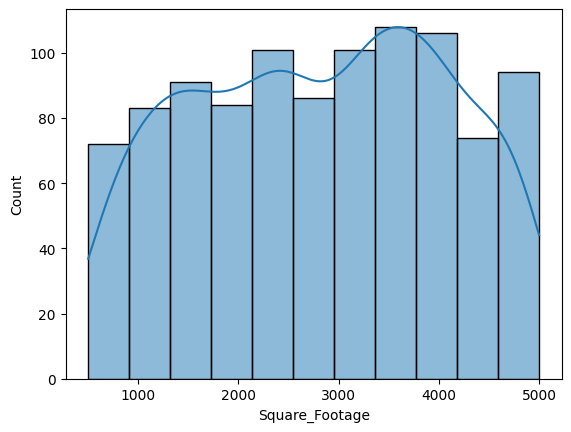

In [15]:
# Variável Square_Footage
sns.histplot(data=df, x="Square_Footage", kde=True)

In [16]:
# Média
df["Square_Footage"].mean()

np.float64(2815.422)

In [17]:
# Mediana
df["Square_Footage"].median()

2862.5

In [18]:
# Desvio padrão
df["Square_Footage"].std()

1255.5149205133457

In [19]:
# Coeficiente de variação
df["Square_Footage"].std() / df["Square_Footage"].mean() * 100

np.float64(44.59420010617753)

Será se a variável Square_Footage influencia no preço da casa?

<Axes: xlabel='House_Price', ylabel='Square_Footage'>

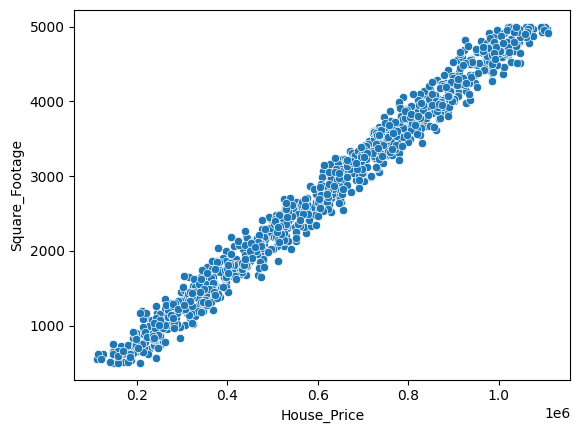

In [20]:
# Gráfico de dispersão
sns.scatterplot(data=df, y="Square_Footage", x="House_Price")

In [21]:
# Teste de hipótese
H0 = "Não há relação entre a variável Square_Footage e House_Price"
Ha = "Há relação entre a variável Square_Footage e House_Price"

Antes de realizar o teste de hipótese precisamos verificar se vamos usar um teste paramétrico ou não paramétrico

In [22]:
# Teste de hipótese de distribuição normal
teste_square = shapiro(df["Square_Footage"])
teste_price = shapiro(df["House_Price"])

if teste_price.pvalue < 0.05 and teste_square.pvalue < 0.05:
  print("Nossas variáveis não são normais, devemos usar um teste não paramétrico")
else:
  print("Nossas variáveis são normais, vamos usar um teste paramétrico")

Nossas variáveis não são normais, devemos usar um teste não paramétrico


In [23]:
teste_h = spearmanr(df["Square_Footage"], df["House_Price"])

if teste_h.pvalue < 0.05:
  print(f"Rejeitamos a Hipótese nula: {H0}")
  print(f"E seguimos com Hipótese alternativa: {Ha}")

Rejeitamos a Hipótese nula: Não há relação entre a variável Square_Footage e House_Price
E seguimos com Hipótese alternativa: Há relação entre a variável Square_Footage e House_Price


In [24]:
teste_h.correlation

np.float64(0.9916017947296666)

Temos uma correlação forte e com direção positiva ou seja a medida que a casa tem maior metragem em metros quadrados o preço tende a ser maior

Qual a média de metros quadrados para casas com quantidade de banheiros e quartos diferentes?

In [25]:
# Media de metros quadrados das casas por quantidades de quartos
df.groupby("Num_Bedrooms")["Square_Footage"].agg(["mean","median"]).reset_index()

,Num_Bedrooms,mean,median
0,1,2876.482587,2989.0
1,2,2772.660465,2755.0
2,3,2997.192308,3216.5
3,4,2766.319797,2690.0
4,5,2686.209756,2656.0


In [26]:
# Media de metros quadrados das casas por quantidades de banheiros
df.groupby("Num_Bathrooms")["Square_Footage"].agg(["mean","median"]).reset_index()

,Num_Bathrooms,mean,median
0,1,2844.300000,2977.0
1,2,2852.981651,2935.0
2,3,2746.105263,2692.0


Será se a quantidade de quartos e banheiros influencia no tamanho da casa em metros quadrados?

In [27]:
# Criando a variável Banheiros + Quartos
df["Bathrooms_Bedrooms"] = df["Num_Bedrooms"] + df["Num_Bathrooms"]

<Axes: xlabel='Bathrooms_Bedrooms', ylabel='Square_Footage'>

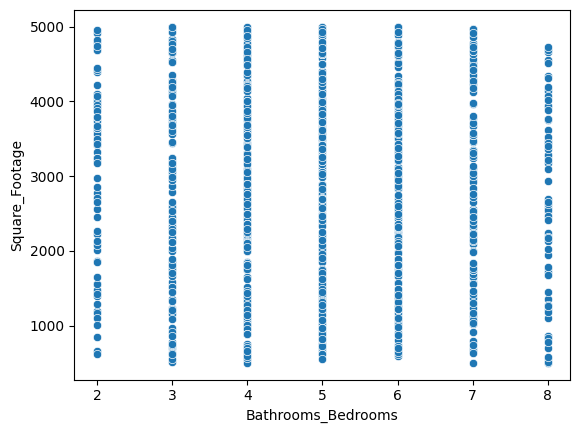

In [28]:
sns.scatterplot(data=df, y="Square_Footage", x="Bathrooms_Bedrooms")

In [29]:
# Teste de hipótese
H0 = "Não há relação entre a variável Square_Footage e Bathrooms_Bedrooms"
Ha = "Há relação entre a variável Square_Footage e Bathrooms_Bedrooms"

In [30]:
# Teste de hipótese de distribuição normal
teste_bath_beed = shapiro(df["Bathrooms_Bedrooms"])

if teste_bath_beed.pvalue < 0.05 and teste_square.pvalue < 0.05:
  print("Nossas variáveis não são normais, devemos usar um teste não paramétrico")
else:
  print("Nossas variáveis são normais, vamos usar um teste paramétrico")

Nossas variáveis não são normais, devemos usar um teste não paramétrico


In [31]:
teste_h2 = spearmanr(df["Square_Footage"], df["Bathrooms_Bedrooms"])

if teste_h2.pvalue < 0.05:
  print(f"Rejeitamos a Hipótese nula: {H0}")
  print(f"E seguimos com Hipótese alternativa: {Ha}")
else:
  print(f"Não rejeitamos a Hipótese nula: {H0}")

Não rejeitamos a Hipótese nula: Não há relação entre a variável Square_Footage e Bathrooms_Bedrooms


Realmente tanto pela visualização do gráfico de dispersão e o teste de hipótese, podemos deduzir que a partir de nossos dados a quantidade de quartos e banheiros na casa não influencia no tamanho da casa em metros quadrados

In [32]:
df.groupby("Bathrooms_Bedrooms")["Square_Footage"].agg(["mean","median"]).reset_index()

,Bathrooms_Bedrooms,mean,median
0,2,3046.116883,3324.0
1,3,2865.382353,2980.5
2,4,2836.164021,2827.0
3,5,2770.142180,2704.0
4,6,2762.953125,2718.0
5,7,2840.622951,2881.5
6,8,2652.068493,2651.0


Qual a quantidade de casas construidas em determinada faixa de ano:

In [33]:
# Calculo para encontar o melhor intervalo entre os dados
amplitude = df["Year_Built"].max() - df["Year_Built"].min()
linhas = round(math.sqrt(df.shape[0]))

In [34]:
# Encontrando o número natural para usar no calculo e achar o melhor intervalo entre os dados
for i in range(1,30,1):
  ic = round(amplitude + i) / linhas
  print(f"Número Natural {i}: {ic}")

Número Natural 1: 2.28125
Número Natural 2: 2.3125
Número Natural 3: 2.34375
Número Natural 4: 2.375
Número Natural 5: 2.40625
Número Natural 6: 2.4375
Número Natural 7: 2.46875
Número Natural 8: 2.5
Número Natural 9: 2.53125
Número Natural 10: 2.5625
Número Natural 11: 2.59375
Número Natural 12: 2.625
Número Natural 13: 2.65625
Número Natural 14: 2.6875
Número Natural 15: 2.71875
Número Natural 16: 2.75
Número Natural 17: 2.78125
Número Natural 18: 2.8125
Número Natural 19: 2.84375
Número Natural 20: 2.875
Número Natural 21: 2.90625
Número Natural 22: 2.9375
Número Natural 23: 2.96875
Número Natural 24: 3.0
Número Natural 25: 3.03125
Número Natural 26: 3.0625
Número Natural 27: 3.09375
Número Natural 28: 3.125
Número Natural 29: 3.15625


In [35]:
# Número natural igual deve ser a 24
ic = round(amplitude + 24) / linhas

In [36]:
# Definindo os intervalos que vão ser usados
bins = [df["Year_Built"].min()] # Inicializa o min da variável
cont = 0
while bins[cont] < df["Year_Built"].max():
    aux = bins[cont] + ic
    bins.append(aux)
    cont += 1

In [37]:
# Criando os labels de intervalo
labels = [f"{int(bins[i])} - {int(bins[i+1])}" for i in range(len(bins) - 1)]

In [38]:
# Mapeando os intervalos (labels) no dataframe a partir da variável "Year_Built"
df["Year_Built_Interval"] = pd.cut(df["Year_Built"], bins=bins,
                                   labels=labels,right=False)

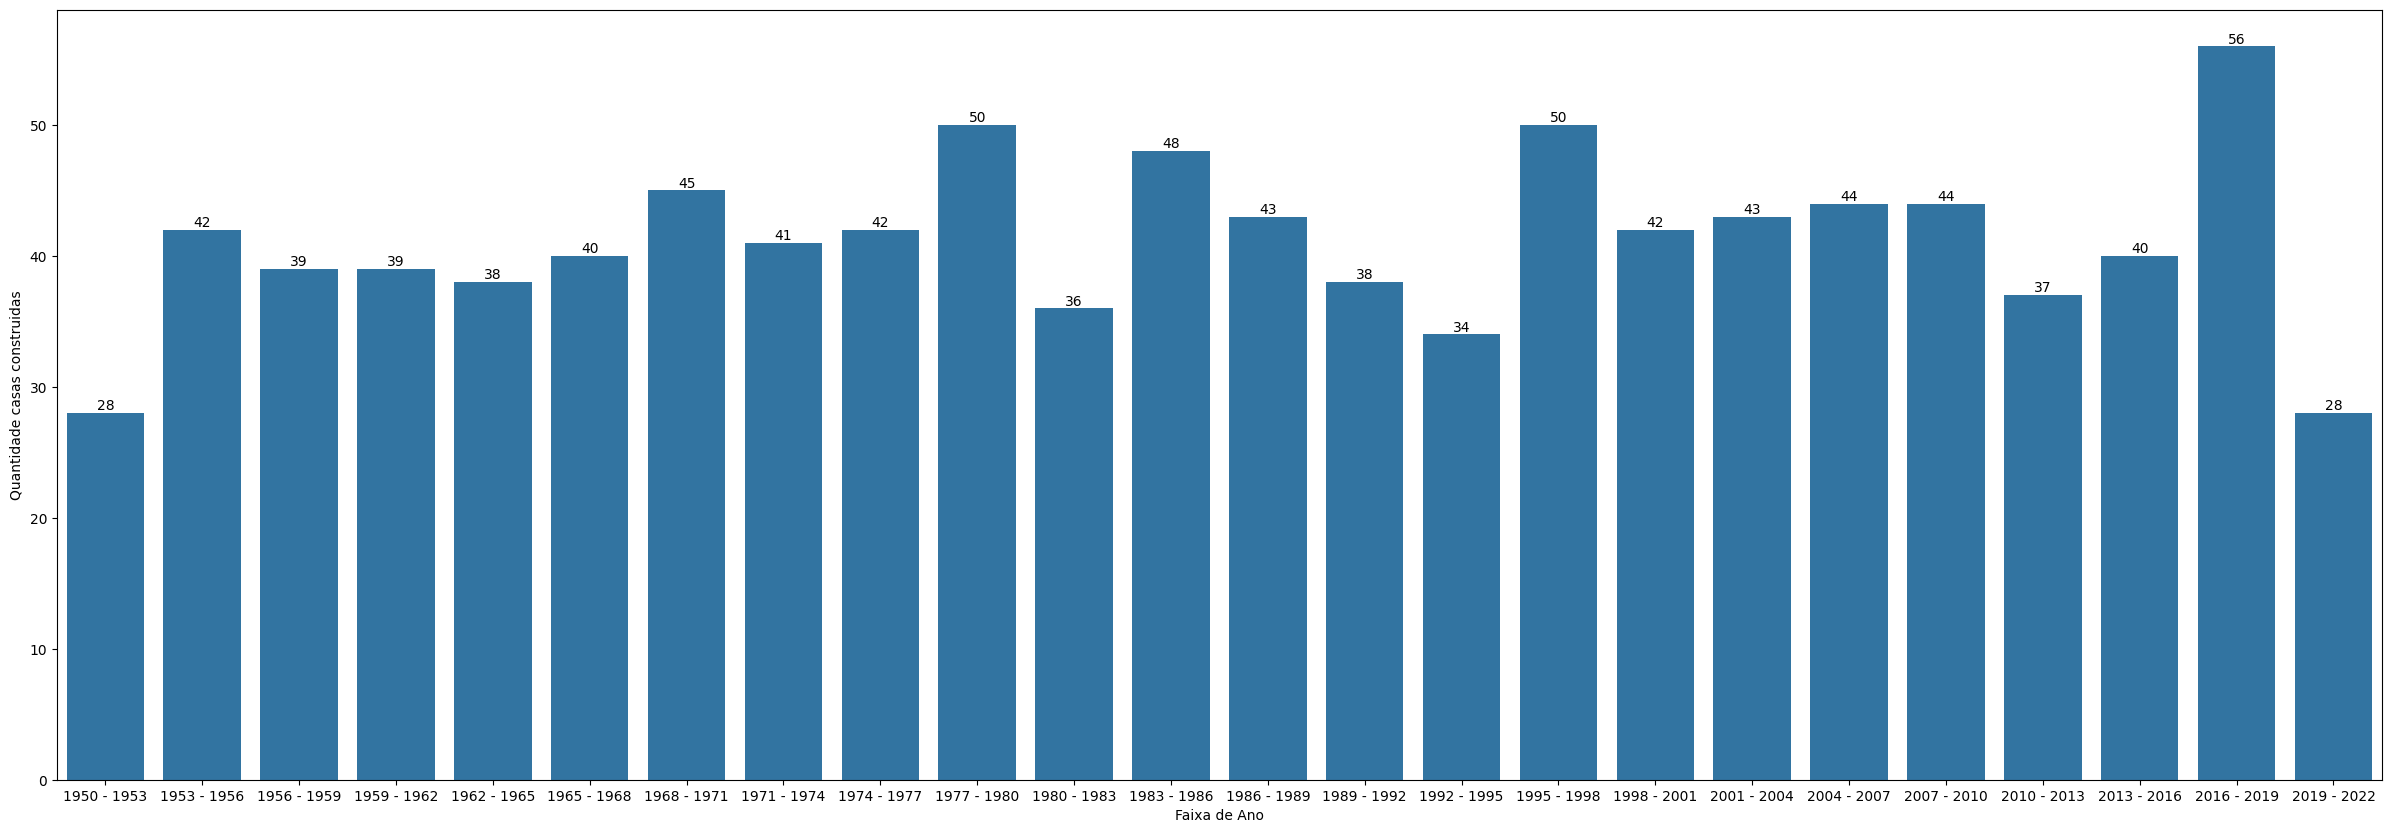

In [39]:
plt.figure(figsize=(30,10))
ax = sns.countplot(data=df, x="Year_Built_Interval")
ax.bar_label(ax.containers[0])
plt.ylabel("Quantidade casas construidas")
plt.xlabel("Faixa de Ano")
plt.show()

Será se o ano de construção da casa influencia no preço da casa?

<Axes: xlabel='House_Price', ylabel='Year_Built'>

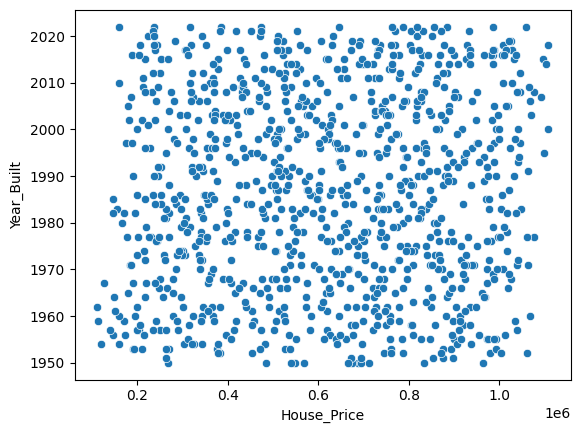

In [40]:
sns.scatterplot(data=df, y="Year_Built", x="House_Price")

<Axes: xlabel='House_Price', ylabel='Age_House'>

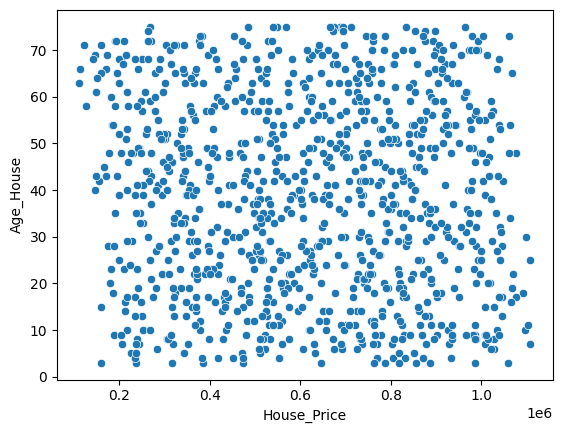

In [41]:
sns.scatterplot(data=df, y="Age_House", x="House_Price") # Aqui usamos a variável que criamos (idade da casa) que representa a mesma informação

In [42]:
# Teste de hipótese
H0 = "Não há relação entre a variável Year_Built e House_Price"
Ha = "Há relação entre a variável Year_Built e House_Price"

In [43]:
# Realizando o teste de hipótese
teste_built = shapiro(df["Year_Built"])
teste_built2 = shapiro(df["Age_House"])
teste_price = shapiro(df["House_Price"])

if teste_built.pvalue < 0.05 and teste_built2.pvalue < 0.05 and teste_price.pvalue < 0.05:
  print("Nossas variáveis não são normais, devemos usar um teste não paramétrico")
else:
  print("Nossas variáveis são normais, vamos usar um teste paramétrico")

Nossas variáveis não são normais, devemos usar um teste não paramétrico


In [44]:
teste_h3 = spearmanr(df["Year_Built"], df["House_Price"])

if teste_h3.pvalue < 0.05:
  print(f"Rejeitamos a Hipótese nula: {H0}")
  print(f"E seguimos com Hipótese alternativa: {Ha}")
else:
  print(f"Não rejeitamos a Hipótese nula: {H0}")

Não rejeitamos a Hipótese nula: Não há relação entre a variável Year_Built e House_Price


Não temos evidencias suficientes para acreditar que o ano em que a casa foi construida influencia no preço da casa